# Get started

In this tutorial, we will illustrate how to annotate the clustering results from UNIFAN, using the coefficients learned by UNIFAN. Again, we will use the Limb_Muscle tissue in the Tabula Muris dataset as an example. 


**Table of Content**

1. [Set up parameters, training enviroments & outputs paths](#1)
2. [Load data](#2) 
3. [Visualize the low-dimensional representation learned by UNIFAN](#3)
4. [Annotate clusters](#4) 

In [1]:
import os
import sys
import gc
import itertools

import torch
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import umap
from tqdm import tqdm
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.model_selection import train_test_split 

# from context import unifan 
from unifan.datasets import AnnDataset, NumpyDataset
from unifan.annocluster import AnnoCluster
from unifan.autoencoder import autoencoder
from unifan.classifier import classifier
from unifan.utils import getGeneSetMatrix, str2bool, seed_torch
from unifan.trainer import Trainer

# 1. Set up parameters, training enviroments & outputs paths (user-specified)
<a id=1></a>

In this section, we will set up the variables related to the datasets, training conditions and specify the hyperparameter values just as what we do in the UNIFAN_example.ipynb tutorial where we train the model. We will also 
initialize the file paths to all outputs which will be read in and analyzed. Other than these, we will also set the selection criteria for the gene sets and genes to annotate the clusters.

Again, this is the **<span style="color: red;">only</span>** step requiring users' inputs. 

### Set selection criteria for the gene sets / genes

The cutoff value is for selecting the genes. Genes higher than the cutoff will be selected. The top K value is for selecting the gene sets. Top k gene sets will be selected, based on the coefficients.

Here we use example values for these two variables and you may set more or less stringent values if you want to select fewer or more gene sets / genes. 

In [2]:
cutoff = 0.01
top_k = 20

### Set up variables related to data 

In [3]:
project = "tabula_muris"
tissue = "Limb_Muscle"

data_filepath = f"../example/input/{tissue}_facts_processed_3m.h5ad"
output_path = "../example/output/"
gene_sets_path = "../gene_sets/"

label_name = "cell_ontology_class"
variable_gene_name = "highly_variable"

random_seed = 0

### Set up training conditions 

In [4]:
use_cuda = False
num_workers = 8

# ------- no need to change the following -------
device = torch.device("cuda" if use_cuda else "cpu")
if use_cuda:
    pin_memory = True
    non_blocking = True
else:
    pin_memory = False
    non_blocking = False

### Set hyperparameters values
1. We use default values for **all** hyperparameters in this tutorial. 

In [5]:
prior_name = "c5.go.bp.v7.4.symbols.gmt+c2.cp.v7.4.symbols.gmt+TF-DNA"
features_type = "gene_gene_sets"
alpha = 1e-2
beta = 1e-5
weight_decay = 1e-3
tau = 10
z_dim = 32

In [6]:
batch_size = 128

num_epochs_classifier = 50 
num_epochs_r = 70
num_epochs_z = 50
r_epoch = num_epochs_r - 1
z_epoch = num_epochs_z - 1
num_epochs_annocluster = 25  

# configuration for the gene set activity scores model 
r_encoder_layers = 5
r_decoder_layers = 1  # need to fixed at 1 if using gene set matrix for decoder 
r_encoder_dim = 128
r_decoder_dim = 128  # actually not used if using gene set matrix for decoder 
rnetwork = 'non-negative'

# configuration for the AnnoCluster model
z_encoder_layers = 3
z_decoder_layers = 2
z_encoder_dim = 128
z_decoder_dim = 128

### Initialize paths to outputs (no need user-input)

Here we set up the paths to save the outputs. The outputs are:

1. Gene set activity scores model:
    1. Gene set activity scores model (input_r_ae_path)
    2. Gene set activity scores (input_r_path) & processed gene set activity scores
    3. Names of the features in the processed gene set activity scores (input_r_names_path)
    4. Training stats (i.e. Trainining loss, validation loss, loss for different terms etc.)
2. Pretrain results of the AnnoCluster model:
    1. Pretrained AnnoCluster model (input_ae_path)
    2. Initial z_e / low-dimensional representation of the samples (input_z_path)
    3. Initialized cluster assignment (input_cluster_path)
    4. Training stats (i.e. Trainining loss, validation loss etc.)
3. Pretrain results of the annotator model:
    1. Pretrained annotator model
    2. Training stats (i.e. Trainining loss, validation loss etc.)
4. Training results of both annotator and AnnoCluster models: 
    1. Trained AnnoCluster and annotator model (saved in a single file) 
    2. Cluster assignments (annocluster_clusters_pre_{training epochs - 1}.npy)
    3. z_e / low-dimensional representation of the samples (annocluster_{training epochs - 1}.npy)
    4. Training stats (i.e. Trainining loss, validation loss, loss for different terms, ARI and NMI based on the final clustering results etc.)
    
All models are saved as dictionaries, with keys "epoch", "state_dict" and "optimizer". For models trained together (final step, AnnoCluster with annotator), model 2 (annotator after the final step) is saved in "state_dict_2" and "optimizer_2".

In [7]:
# ------ prepare for output
output_parent_path = f"{output_path}{project}/{tissue}/"

r_folder = f"{output_parent_path}r"
input_r_ae_path = os.path.join(r_folder, f"r_model_{r_epoch}.pickle")
input_r_path = os.path.join(r_folder, f"r_{r_epoch}.npy")
input_r_names_path = os.path.join(r_folder, f"r_names_{r_epoch}.npy")

pretrain_z_folder = f"{output_parent_path}pretrain_z"
input_z_path = os.path.join(pretrain_z_folder, f"pretrain_z_{z_epoch}.npy")
input_ae_path = os.path.join(pretrain_z_folder, f"pretrain_z_model_{z_epoch}.pickle")
input_cluster_path = os.path.join(pretrain_z_folder, f"cluster_{z_epoch}.npy")

pretrain_annotator_folder = f"{output_parent_path}pretrain_annotator"
annocluster_folder = f"{output_parent_path}annocluster_{features_type}"

# 2. Load data 
<a id=2></a>

In [8]:
# ------ load data
if features_type in ["gene", "gene_gene_sets"]:
    expression_only = AnnDataset(data_filepath, label_name=label_name, variable_gene_name=variable_gene_name)
    exp_variable_genes = expression_only.exp_variable_genes
    variable_genes_names = expression_only.variable_genes_names
else:
    expression_only = AnnDataset(data_filepath, label_name=label_name)
    exp_variable_genes = None
    variable_genes_names = None

genes_upper = expression_only.genes_upper
clusters_true = expression_only.clusters_true
N = expression_only.N
G = expression_only.G

# 3. Visualize the low-dimensional representation learned by UNIFAN
<a id=3></a>

In [9]:
# load saved results 
z_final = np.load(os.path.join(annocluster_folder, f"annocluster_{num_epochs_annocluster - 1}.npy"))
clusters_pre = np.load(os.path.join(annocluster_folder, f"annocluster_clusters_pre_{num_epochs_annocluster - 1}.npy"))

In [10]:
# get non-empty clusters 
unique_clusters = list(np.unique(clusters_pre))
# re-index the clusters (given empty clusters are removed)
clusters_pre_reidx = np.array([unique_clusters.index(c) for c in clusters_pre])

# calculate evaluation metrics 
if clusters_true is not None:
    # load subset index for calculating ARI
    if N > 5e4:
        idx_stratified, _ = train_test_split(range(N), test_size=0.5, stratify=clusters_true)
    else:
        idx_stratified = range(N)
    ari_smaller = adjusted_rand_score(clusters_pre_reidx[idx_stratified],
                                      clusters_true[idx_stratified])
    nmi_smaller = adjusted_mutual_info_score(clusters_pre_reidx, clusters_true)
else:
    ari_smaller = np.nan
    nmi_smaller = np.nan

# generate 2-dimension UMAP 
umap_original = umap.UMAP().fit_transform(z_final)

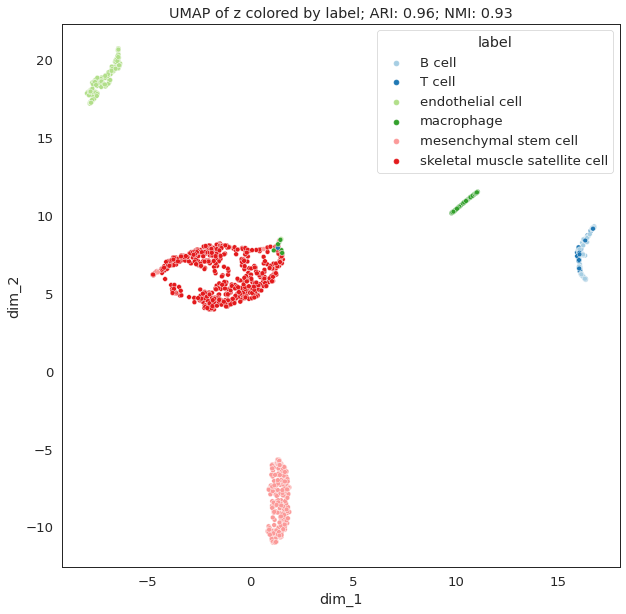

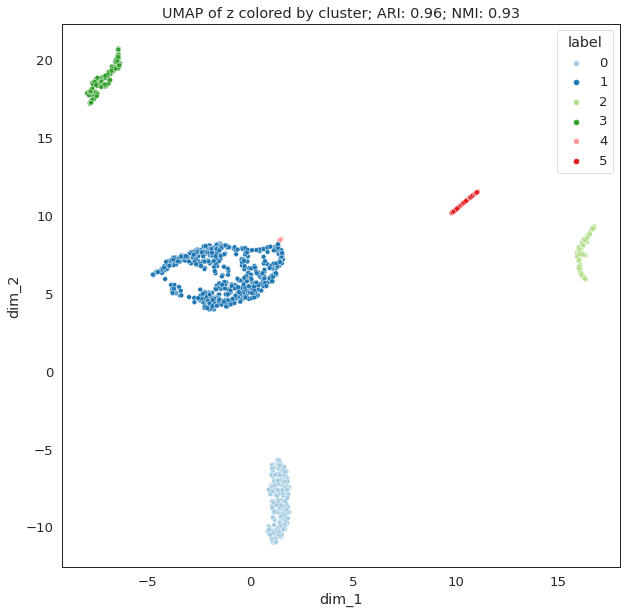

In [11]:
# plot the visualization 
sns.set_style("white")
sns.set_context("paper", font_scale=1.5)

# color by cluster
hues = {'label': clusters_true, 'cluster': clusters_pre_reidx}
for k, v in hues.items():
    df_plot = pd.DataFrame(umap_original)
    if v is None:
        df_plot['label'] = np.repeat("Label not available", df_plot.shape[0])
    else:
        df_plot['label'] = v
    df_plot['label'].astype('str')
    df_plot.columns = ['dim_1', 'dim_2', 'label']

    plt.figure(figsize=(10, 10))
    sns.scatterplot(x='dim_1', y='dim_2', hue='label', data=df_plot, palette="Paired", legend=True)
    plt.title(f"UMAP of z colored by {k}; ARI: {round(ari_smaller, 2)}; NMI: {round(nmi_smaller, 2)}")
#     plt.savefig(os.path.join(annocluster_folder, f"z_{z_epoch}_{k}.png"), bbox_inches="tight", format="png")
    plt.show()
    plt.close()


# 4. Annotate clusters
<a id=4></a>

### Preprocess the saved feature (gene sets / genes) names  

In [12]:
# load feature names 
input_r_names_path = f"{input_r_names_path}_filtered_{features_type}.npy"
set_names = list(np.load(input_r_names_path))

# process feature names; to distinguish TF names and marker gene names 
if features_type == "gene_gene_sets":
    n_variable_genes = 2000
    
    set_names_gene_set = set_names[:len(set_names) - n_variable_genes]
    variable_genes_names = set_names[-n_variable_genes:]  

    new_set_names_gene_set = []
    for _n in set_names_gene_set:
        _splits = _n.split("_")
        if len(_splits) == 1:
            _new_name = _n + "_TF"
            new_set_names_gene_set.append(_new_name)
        else:
            new_set_names_gene_set.append(_n)

    set_names = list(new_set_names_gene_set) + variable_genes_names
    set_names = np.array(set_names)
    new_set_names_gene_set = np.array(new_set_names_gene_set)
      
else:
    pass 

### Load learned coefficients 

Text(0.5, 1.0, 'Classifier coefficients for each cluster')

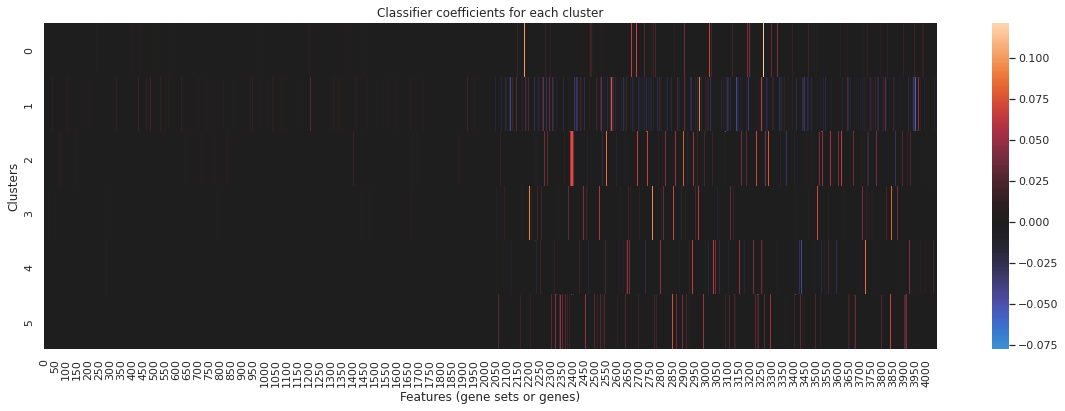

In [13]:
model_dict = torch.load(os.path.join(annocluster_folder, f"annocluster_model_{num_epochs_annocluster - 1}.pickle"))
weights = model_dict['state_dict_2']['decoder.predictor.0.weight'].detach().numpy()
sub_weights = weights[unique_clusters, :]

df_plot = pd.DataFrame(sub_weights)

sns.set_theme()
plt.figure(figsize=(20, 6))
ax = sns.heatmap(df_plot, center = 0)
plt.xlabel("Features (gene sets or genes)")
plt.ylabel("Clusters")
plt.title("Classifier coefficients for each cluster")

### Select representative gene sets or genes for each cluster 

1. Select gene sets or genes based on their coefficients
2. Also conduct evaluation on the selected genes to see if they are likely marker genes for some cell types
    * briefly, this is done by comparing these genes with known cell type marker gene sets and to see if these cell type marker gene sets are enriched in the selected genes; see our manuscript for more details

In [14]:
# load cell type marker sets for evaluating selected genes 
_name = "c8.all.v7.4.symbols.gmt"

if _name[-3:] == 'gmt':
    print("GMT file loading ... ")
    filename = _name
    filepath = os.path.join(gene_sets_path, filename)

    with open(filepath) as genesets:
        type2gene = {line.strip().split("\t")[0]: line.strip().split("\t")[2:]
                        for line in genesets.readlines()}

    print(len(type2gene))

    gs = []
    for k, v in type2gene.items():
        gs += v
        
    try:
        print(f"Number of genes in prior {len(set(gs).intersection(genes_upper))}")
    except NameError:
        pass

 

GMT file loading ... 
671
Number of genes in prior 12218


##### define functions for the evaluation of (marker) gene selection using cell type marker sets 
Adpated from:
* Author: Chieh Lin
* Project: CSHMM-TF
* Link: https://github.com/jessica1338/CSHMM-TF-for-time-series-scRNA-Seq/blob/master/CSHMM_TF_train_release.py

In [15]:
from scipy.stats import ttest_ind, spearmanr, binom_test
import statsmodels.api as sm
import statsmodels as sm


def getEnrichTF(GeneList, GL, dTD, pcut=0.1, ntop=6, adjusted=True):
    dMb = batchScanPrior([item.upper() for item in GL], dTD)
    dMi = batchScanPrior([item.upper() for item in GeneList], dTD)
    K = [item for item in dMi.keys() if item in dMb.keys()]
    K.sort()

    n = len(GeneList)  # number of selected genes
    N = len(GL)  # number of background genes

    entf = []
    pvalues = []
    all_tfs = []
    for i in K:
        Ti = len(dMi[i])
        Tb = len(dMb[i])
        pr = float(Tb) / N
        pvi = pbinom(Ti - 1, n, pr)

        if pvi < pcut:
            entf.append([pvi, i])

        all_tfs += [[pvi, i]]
        pvalues += [pvi]

    if adjusted:
        p_adjusted = sm.stats.multitest.fdrcorrection(pvalues)[1]
        K = np.array(K)
        entf = list(zip(p_adjusted[p_adjusted < pcut], K[p_adjusted < pcut]))
        entf.sort()
    else:
        entf.sort()

    if ntop is not None:
        entf = entf[:ntop]

    return entf, all_tfs


def batchScanPrior(A, dTD):
    # dTD: dictionary of TF-DNA interaction
    # A: Gene list
    K = list(dTD.keys())
    K.sort()
    dA = {item.upper(): 0 for item in A}
    dM = {}
    for i in K:
        GI = [item.upper() for item in dTD[i]]
        GI = list(set([item for item in GI if item in dA]))
        if len(GI) > 0:
            dM[i] = GI
    return dM


def pbinom(x, n, p):
    # handling special cases
    if x < 0:
        return 0
    if n <= 0: 
        return 0
    if x > n:
        return 1

    # use scipy.binom_test to calculate binomial test p-value
    pv = binom_test(x, n, p, alternative="greater")
    if (1 - pv) <= sys.float_info.epsilon / 2:
        return 1
    else:
        return pv


##### conduct selection and evaluation for each cluster

In the following part, we will use the cutoff and the top_k value we set in the first section. 

In [16]:
# initialize
selected_genes_pvalues = []
selected_processes = []

gene_set_weights = sub_weights[:,:len(new_set_names_gene_set)]

In [17]:
for cur_cluster in range(len(unique_clusters)):
    print(f"Process {cur_cluster}")
    
    # select gene sets (biological processes)
    _idx = np.argpartition(gene_set_weights[cur_cluster,:], -top_k)[-top_k:]
    selected = new_set_names_gene_set[_idx]
    
    _df = pd.DataFrame(selected)
    _df.columns = ['set_name']
    _df['cluster'] = cur_cluster
    _df['top_k'] = top_k
    
    selected_processes.append(_df)
    
    # select genes 
    selected = set_names[np.where(sub_weights[cur_cluster,:] > cutoff)[0]]
    selected_gs = []
    for i in selected:
        _splits = i.split("_")
        if len(_splits) == 1:  # this feature is a gene not a gene set 
            selected_gs.append(i)
    print(f"Number of genes selected: {len(selected_gs)}")
    
    GL = list(variable_genes_names)
    GeneList = selected_gs
    
    # pcut and ntop may be modified to adjust the signifcance level or determining 
    # how many top enriched set to be output 
    ensets, _allsets = getEnrichTF(GeneList, GL, type2gene, pcut=0.1, ntop=5)
    
    _df = pd.DataFrame(ensets)
    _df.columns = ['enrich_p', 'set_name']
    _df['cluster'] = cur_cluster
    _df['weight_cutoff'] = cutoff
    
    selected_genes_pvalues.append(_df)

Process 0
Number of genes selected: 166
Process 1
Number of genes selected: 128
Process 2
Number of genes selected: 163
Process 3
Number of genes selected: 148
Process 4
Number of genes selected: 88
Process 5
Number of genes selected: 174


In [18]:
df_summary_processes = pd.concat(selected_processes)
df_summary_genes = pd.concat(selected_genes_pvalues)

### Visualize the selected gene sets with their coefficients

In [19]:
selected_clusters = np.unique(df_summary_processes['cluster'])
idx_selected = [list(new_set_names_gene_set).index(p) for p in df_summary_processes['set_name']]

_weights = gene_set_weights[selected_clusters, :] 
_weights = _weights[:, idx_selected]
_set_names = set_names[idx_selected]

df_plot = pd.DataFrame(_weights)
df_plot.index = selected_clusters
df_plot.columns = _set_names

In [20]:
# replace _ with space for visualization purpose 
def underline2space(_cols, remove_name = False):
    _new_cols = []
    for _c in _cols:
        if remove_name:
            _new_cols.append(" ".join(_c.split("_")[1:]))
        else:
            _new_cols.append(" ".join(_c.split("_")))
    return _new_cols 

df_plot.columns = underline2space(df_plot.columns.values)

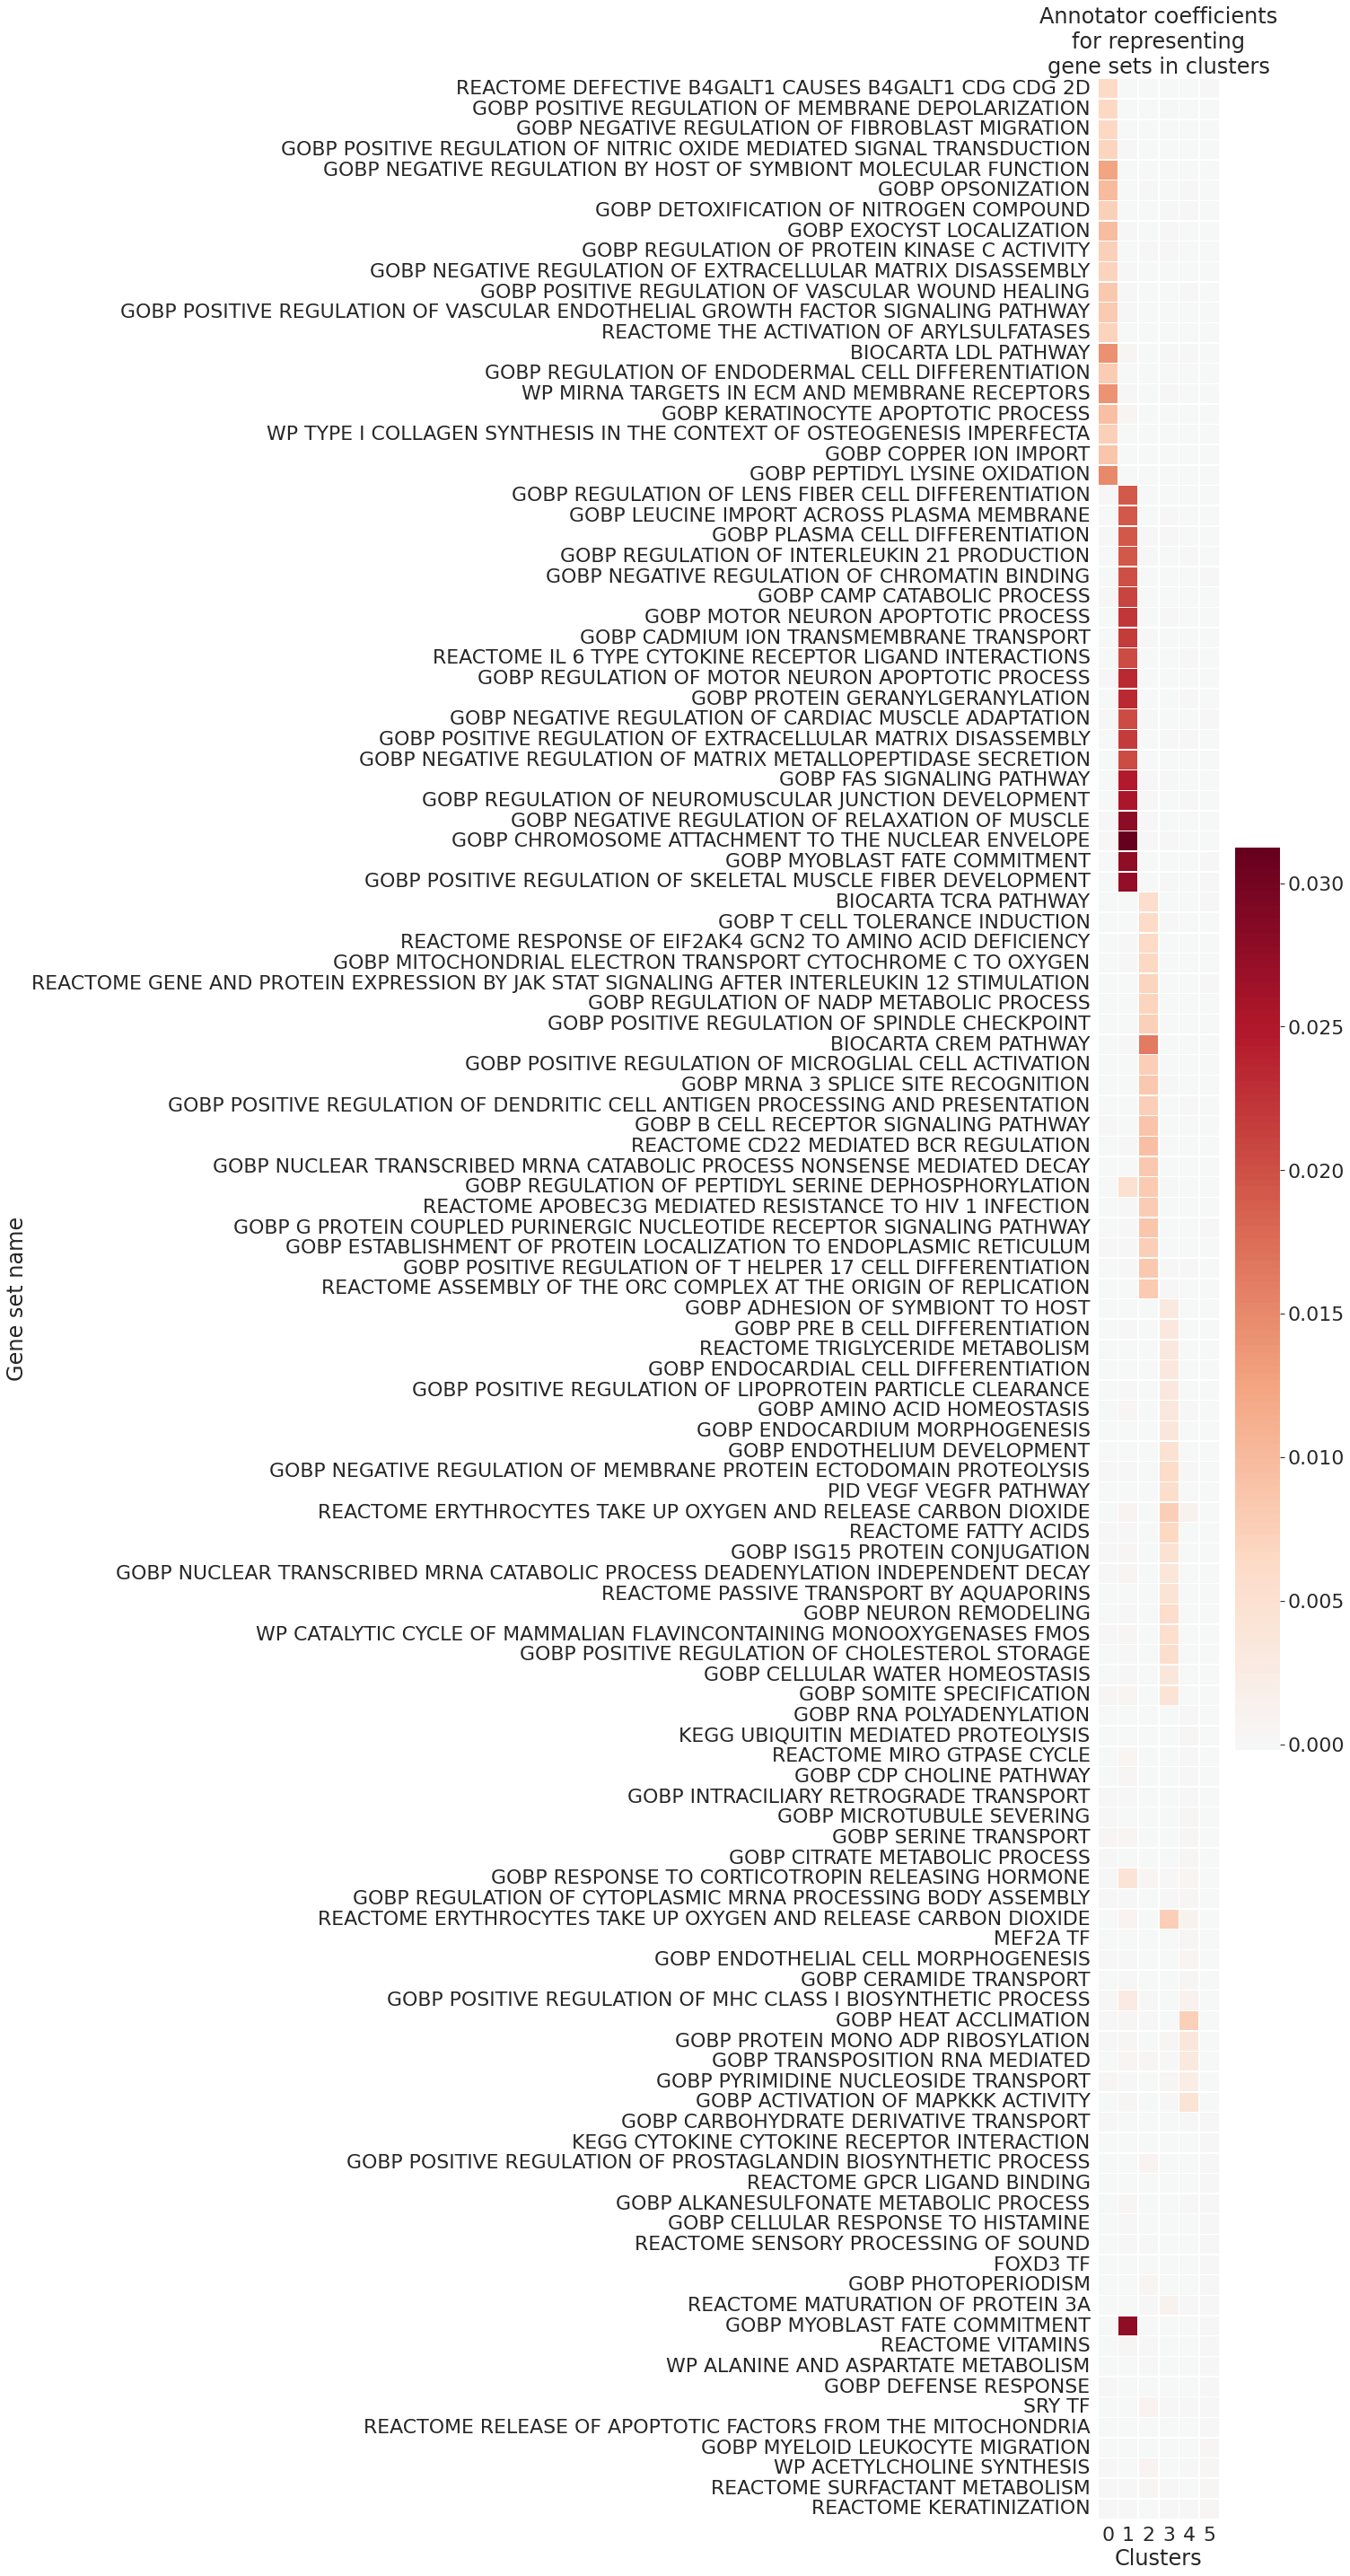

In [21]:
sns.set_style("white")

_font_size = 2.5
    
sns.set_context("paper", font_scale=_font_size) 

plt.figure(figsize=(6, 50))
 

ax = sns.heatmap(df_plot.T, xticklabels=True, yticklabels=True, center = 0, 
                 cmap = "RdBu_r", linewidths=.5, square=True)
plt.xticks(rotation=0)

plt.xlabel("Clusters")
plt.ylabel("Gene set name")
plt.title("Annotator coefficients\nfor representing\ngene sets in clusters")
filename = f"visualize_gene_set.png"
# plt.savefig(os.path.join(annocluster_folder, filename), bbox_inches = "tight", dpi=300, format = "png") 
filename = f"visualize_gene_set.eps"
# plt.savefig(os.path.join(annocluster_folder, filename), bbox_inches = "tight", dpi=300, format = "eps") 

### Visualize the top enriched cell type marker sets in the selected genes

In [22]:
# turn p-value to -log10(p-value)
def p2log(p, lowest=1e-50):
    if p < lowest:
        p = lowest
    return - np.log10(p)

# cap at the lowest non-zero p-value * 1e-5
cur_low = 1
for p in df_summary_genes["enrich_p"]:
    if p != 0:
        if p < cur_low:
            cur_low = p
            
df_summary_genes["-logp"] = [p2log(p, cur_low * 1e-5) for p in df_summary_genes["enrich_p"]]

In [23]:
df_plot = df_summary_genes.pivot(index='set_name', columns='cluster', values='-logp')
df_plot = df_plot.reindex(df_summary_genes["set_name"].drop_duplicates().values)
df_plot = df_plot.fillna(0)
df_plot.index = underline2space(df_plot.index.values)

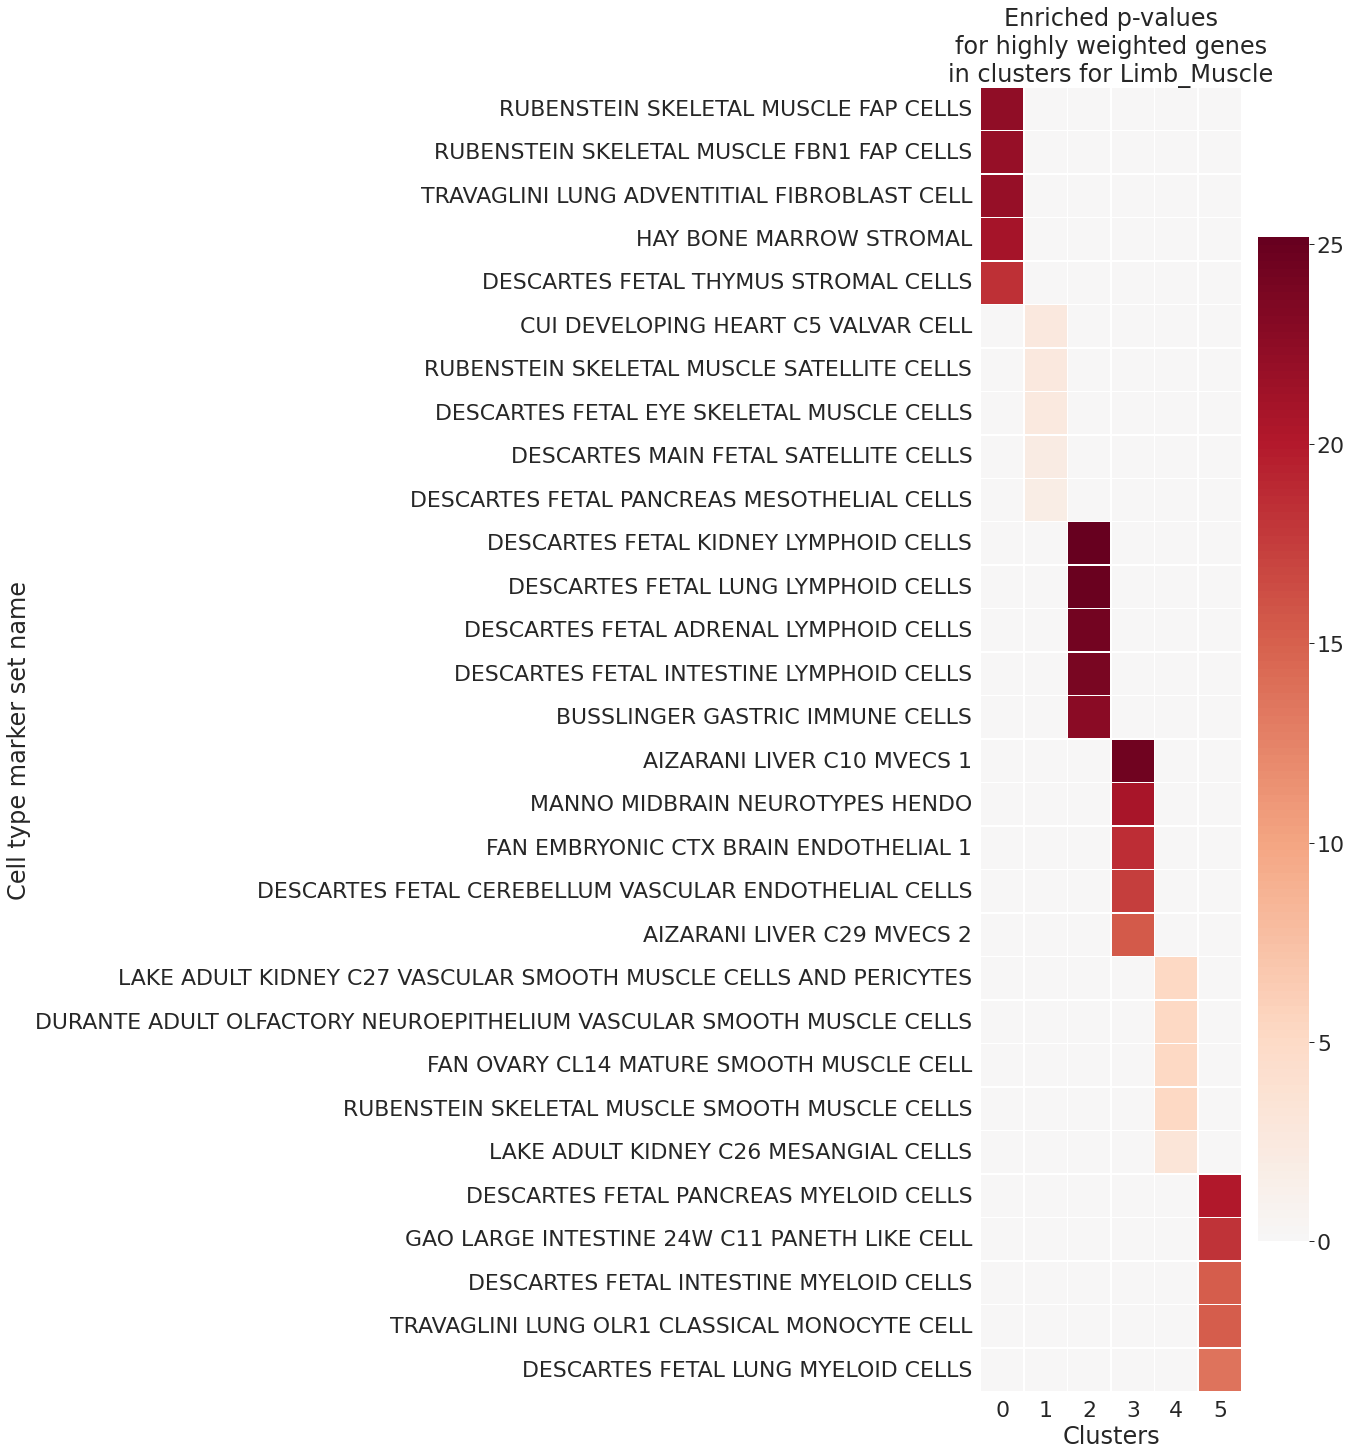

In [24]:
sns.set_style("white")
sns.set_context("paper", font_scale=2.5) 

plt.figure(figsize=(6, 24))


ax = sns.heatmap(df_plot, xticklabels=True, yticklabels=True, center = 0, 
                 cmap = "RdBu_r", linewidths=.5, square=True)
plt.xticks(rotation=0)

plt.xlabel("Clusters")
plt.ylabel("Cell type marker set name")
plt.title(f"Enriched p-values\nfor highly weighted genes\nin clusters for {tissue}")
filename = f"visualize_gene.png"
# plt.savefig(os.path.join(annocluster_folder, filename), bbox_inches = "tight", dpi=300, format = "png") 
filename = f"visualize_gene.eps"
# plt.savefig(os.path.join(annocluster_folder, filename), bbox_inches = "tight", dpi=300, format = "eps") 